Following this guide for understanding and building: https://www.youtube.com/watch?v=TCH_1BHY58I

More on the model: This will be a character level multi-level perceptron model that introduces the use of embeddings to give individual letters more parameters with which to adjust it's weights to. 


The reason we're distancing ourselves from the approach of just doing counts and using that to create a distribution of the probable outcomes it that the matrix containing the counts not only becomes increasingly sparse as more previous characters are added to the string, but the matrix grows at a rate of $n^{x+1}$ where n is the number of unique charaters to predict and x is the the number of characters preceeding the predicted character. 

Example: given only the a single letter and trying to predict the next letter would lead to a $27^2$ matrix since there are 27 characters (including the start/stop character '.') and we only have one letter of context x=1

Using the NN method of applying linear regression to weights and allowing the cost function to manipulate the weights s.t. the cost function is minimized allows for significantly smaller networks to exist and to have more control over the size. Part of having this level of control is being to easily add more layers or adding different kinds of layers like EMBEDDINGS!

And thats what the multi-level perceptron (MLP) model is all about. Just adding embeddings. I think.

In [1]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt


C:\Users\julio\AppData\Roaming\Python\Python38\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Loading in data 
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [13]:
# build vocab 
chars = sorted(list(set(''.join(words)))) # Get all possible letters 
# Apply index based mapping
stoi = {char:i+1 for i,char in enumerate(chars)}
stoi['.'] = 0
itos = {i:char for char, i in stoi.items()}

In [45]:
# Building dataset 
block_size = 3
x=[]
y=[]

for word in words[:6]:
    context = [0] * block_size

    for char in word + '.': #need to add ending indicator
        index = stoi[char]
        print(context)
        x.append(context)
        y.append(index)
        print(''.join(itos[i] for i in context), '----->', itos[y[-1]])
        context = context[1:] + [index]
x = torch.tensor(x)
y = torch.tensor(y)
print(x.shape)

[0, 0, 0]
... -----> e
[0, 0, 5]
..e -----> m
[0, 5, 13]
.em -----> m
[5, 13, 13]
emm -----> a
[13, 13, 1]
mma -----> .
[0, 0, 0]
... -----> o
[0, 0, 15]
..o -----> l
[0, 15, 12]
.ol -----> i
[15, 12, 9]
oli -----> v
[12, 9, 22]
liv -----> i
[9, 22, 9]
ivi -----> a
[22, 9, 1]
via -----> .
[0, 0, 0]
... -----> a
[0, 0, 1]
..a -----> v
[0, 1, 22]
.av -----> a
[1, 22, 1]
ava -----> .
[0, 0, 0]
... -----> i
[0, 0, 9]
..i -----> s
[0, 9, 19]
.is -----> a
[9, 19, 1]
isa -----> b
[19, 1, 2]
sab -----> e
[1, 2, 5]
abe -----> l
[2, 5, 12]
bel -----> l
[5, 12, 12]
ell -----> a
[12, 12, 1]
lla -----> .
[0, 0, 0]
... -----> s
[0, 0, 19]
..s -----> o
[0, 19, 15]
.so -----> p
[19, 15, 16]
sop -----> h
[15, 16, 8]
oph -----> i
[16, 8, 9]
phi -----> a
[8, 9, 1]
hia -----> .
[0, 0, 0]
... -----> c
[0, 0, 3]
..c -----> h
[0, 3, 8]
.ch -----> a
[3, 8, 1]
cha -----> r
[8, 1, 18]
har -----> l
[1, 18, 12]
arl -----> o
[18, 12, 15]
rlo -----> t
[12, 15, 20]
lot -----> t
[15, 20, 20]
ott -----> e
[20, 20, 5]


In [43]:
x

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

In [24]:
#Creating embeddingfs matrix
C = torch.rand((27,2)) #27 rows to match vocab size and only creating a two layer deep set of embeddings, but can be manipulated as you'd like 

In [37]:
x.shape, x.dtype, y.shape, y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [34]:
y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [44]:
C[x].shape

torch.Size([32, 3, 2])

In [47]:
embedding = C[x]
#glossed over this, but whats happening is kind of a reverse, the elements of C (27,2) are being put into x (32,3) based on the contents of the x matrix. So where x maintains the orders and sequences, C injects the respective embedding row based on index
# So if x = [0,1,2](1,3) then C[x] = [C[0], C[1], C[2]](1,3,2) since C has 2 elements per embedding and then to make it workable, C[x].view(x.shape[0],-1) just unpacks it 

In [ ]:
#Layer 1
W1 = torch.randn((6,100)) # number of inputs is 6 since we have a context length of 3 and there are 2 associated layers to that (3x2=6)
b = torch.rand((100))
# embedding * W1 + b, but [32,3,2] wont multiply nicely into [6,100], so need to flatten [32,3,2] --> [32,6]
# to help with the mental math of whats going on, im pretty sure the elements just get flattened! So previously, for the first input of [...] was [[0.3803, 0.1630],[0.3803, 0.1630],[0.3803, 0.1630]] (3x2) is now [0.3803, 0.1630, 0.3803, 0.1630, 0.3803, 0.1630](1x6)

In [65]:
torch.cat([embedding[:,0,:],embedding[:,1,:],embedding[:,2,:]], dim=1) #hard coded example 
torch.cat(torch.unbind(embedding, dim=1), dim=1) # not hard coded, but more generalizable since it unpacks and then concats
embedding.view(42,6) # most memory efficent way, view always works as long as its dimensions multipled equal the element count
print()

In [70]:
#Layer 1
W1 = torch.randn((6,100)) # number of inputs is 6 since we have a context length of 3 and there are 2 associated layers to that (3x2=6)
b1 = torch.randn((100))
h = embedding.view(embedding.shape[0],-1) @ W1 + b1 # the -1 means make this work, so it will always output correct dimension
h = torch.tanh(h) #applying activation function

In [71]:
h.shape

torch.Size([42, 100])

In [90]:
# Layer 2
W2 = torch.randn(100,27) #since this is the output layer and need to output 1 of 27 characters
b2 = torch.randn(27)
input = h @ W2 + b2
m = torch.nn.Softmax(dim=1)
output = m(input)
loss = -output[torch.arange(42), y].log().mean()

In [89]:
torch.arange(42)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41])

In [91]:
output[0]

tensor([1.5390e-04, 9.5878e-11, 8.3701e-01, 8.0869e-08, 1.2492e-08, 1.0315e-06,
        1.6220e-01, 1.9988e-14, 2.3743e-09, 7.6095e-08, 1.5902e-09, 7.5176e-07,
        9.9780e-14, 8.0132e-10, 2.3634e-07, 3.9850e-08, 5.0612e-14, 2.5833e-08,
        1.0204e-07, 6.7592e-07, 8.0086e-08, 5.5153e-08, 8.4450e-09, 1.7960e-07,
        6.3426e-04, 3.1066e-09, 1.9387e-06])

In [103]:
# Building dataset 
block_size = 3
x=[]
y=[]

for word in words:
    context = [0] * block_size

    for char in word + '.': #need to add ending indicator
        index = stoi[char]
        #print(context)
        x.append(context)
        y.append(index)
        #print(''.join(itos[i] for i in context), '----->', itos[y[-1]])
        context = context[1:] + [index]
x = torch.tensor(x)
y = torch.tensor(y)

In [126]:
# Rewritten for clarity 
num_emb = 2
total_emb_dim = num_emb * block_size
middle_nodes = 100
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,num_emb), generator=g)
W1 = torch.randn((total_emb_dim,middle_nodes), generator=g) # number of inputs is 6 since we have a context length of 3 and there are 2 associated layers to that (3x2=6)
b1 = torch.randn((middle_nodes), generator=g)
W2 = torch.randn((middle_nodes,27), generator=g) #since this is the output layer and need to output 1 of 27 characters
b2 = torch.randn((27), generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True


In [105]:
for _ in range(10):
    # forward pass
    embedding = C[x]
    h = torch.tanh(embedding.view(embedding.shape[0],-1) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y) #quicker version of taking softmax and calculating loss, makes forward and backward passes much more efficient and behaves well with large numbers
    # Backwards Pass
    for p in parameters:
        p.grad = None #resets gradients to 0 every pass
    loss.backward() #applies loss changes to respective gradients
    for p in parameters:
        p.data += -0.1 * p.grad # applies loss to the weight and bias parameters
        
print(loss.item())

11.051857948303223


In [112]:
# Using trial and error, establish a high, but not unstable, learning rate parameter and low. 
# Then apply them to the learning rate sequentially
lre = torch.linspace(-3,0,1000) # learning rate exponent
lrs = 10**lre

In [244]:
mini = torch.randint(0, x.shape[0],(32,), generator=g)
mini

tensor([173068, 204191, 194857, 104517, 201833, 177231, 180879, 180515, 146871,
        154978, 184791, 196569, 102808, 138660, 130020, 192944, 125448,    160,
        125175,  15949, 190961,  52404, 177121, 142065,  83789, 220984, 199946,
        119327, 124497,  15022, 189506, 181576])

In [127]:
#lri = []
#lossi = []
# But mini batch gradient descent is better, so 
for i in range(10000):
    mini = torch.randint(0, x.shape[0],(32,), generator=g)
    # forward pass
    embedding = C[x[mini]]
    h = torch.tanh(embedding.view(embedding.shape[0],-1) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y[mini]) #quicker version of taking softmax and calculating loss, makes forward and backward passes much more efficient and behaves well with large numbers
    # Backwards Pass
    for p in parameters:
        p.grad = None #resets gradients to 0 every pass
    loss.backward()
    #lr = lrs[i] #applies loss changes to respective gradients
    for p in parameters:
        p.data += -0.1 * p.grad # applies loss to the weight and bias parameters
    #lri.append(lre[i])
    #lossi.append(loss.item())

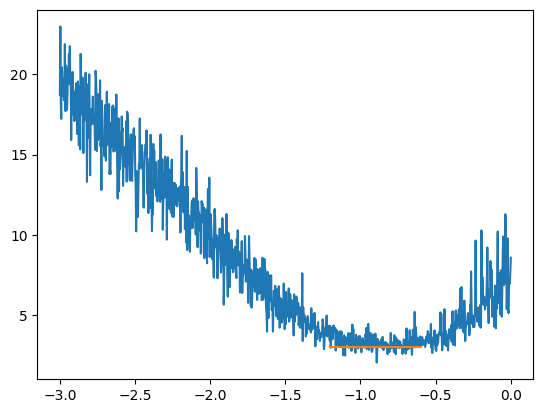

In [125]:
plt.plot(lri,lossi)
plt.plot([-1.2, -0.6], [3, 3])
# Any gain is good gain, but the optimal spot is in the range of the orange line after the elbow
# At the optimal point, loss is at a minimum and the results are the least noisy 

In [128]:
# Since mini-batch GD only outputs the loss on the batch, we can apply the forward pass and calc loss to see what the avg loss is on the whole dataset
embedding = C[x]
h = torch.tanh(embedding.view(embedding.shape[0],-1) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y)
loss

tensor(2.5214, grad_fn=<NllLossBackward0>)

#### Final bit:

Now that all of the parts work and there is an established learning rate, the only thing left to do is get a good accuracy measuremeant via train/dev/test split

In [134]:
def build_dataset(words, block_size= 3):
    x=[]
    y=[]

    for word in words:
        context = [0] * block_size

        for char in word + '.': #need to add ending indicator
            index = stoi[char]
            x.append(context)
            y.append(index)
            context = context[1:] + [index]
    x = torch.tensor(x)
    y = torch.tensor(y)
    return x, y 

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

xtr, ytr = build_dataset(words[:n1])
xval, yval = build_dataset(words[n1:n2])
xtest,ytest = build_dataset(words[n2:])


In [140]:
# NN Architecture
num_emb = 2
total_emb_dim = num_emb * block_size
middle_nodes = 100
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,num_emb), generator=g)
W1 = torch.randn((total_emb_dim,middle_nodes), generator=g) # number of inputs is 6 since we have a context length of 3 and there are 2 associated layers to that (3x2=6)
b1 = torch.randn((middle_nodes), generator=g)
W2 = torch.randn((middle_nodes,27), generator=g) #since this is the output layer and need to output 1 of 27 characters
b2 = torch.randn((27), generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [141]:
# Clean forward, backwards, and updates
def update_weights(xdata, ydata, runs, lr=0.1):
    for i in range(runs):
        #batch
        mini = torch.randint(0, xdata.shape[0],(32,), generator=g)
        #forward
        embedding = C[xdata[mini]]
        h = torch.tanh(embedding.view(embedding.shape[0],-1) @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, ydata[mini]) 
        for p in parameters:
            p.grad = None #
        #back
        loss.backward()
        #update
        for p in parameters:
            p.data += -lr * p.grad

In [142]:
def loss_calc(xdata, ydata):
    embedding = C[xdata]
    h = torch.tanh(embedding.view(embedding.shape[0],-1) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, ydata)
    return loss.item()

In [139]:
xtr, ytr = build_dataset(words[:n1])
xval, yval = build_dataset(words[n1:n2])
xtest,ytest = build_dataset(words[n2:])

2.4971537590026855

In [224]:
train_loss = update_weights(xtr, ytr, 10000, lr=0.01)

In [225]:
loss_calc(xtr,ytr)

2.0628106594085693

In [226]:
loss_calc(xval,yval)

2.164951801300049

In [227]:
runner_up = loss_calc(xval,yval)
if runner_up < current_best:
    current_best = runner_up
print(current_best)

2.164951801300049


In [229]:
loss_calc(xtest,ytest)

2.1531989574432373

### Steps taken to determine what to adjust: 

##### Warning: More complex networks take more time to converge

- Train and dev are not super far away. This is a result of the model complex enough to overfit and memorize the inputs. Therefore: underfitting (could do better) ----> make more complex by scaling somethign up (100 nodes -> 300 nodes) 
- Once training doesn't seem to improve much (could run a SMA) reduce learning rate and try again for fine tuning or increase batch size
- Train and dev continue to be close, but model isn't improving much anymore, so the bottleneck might be somewhere else. Therefore: underfitting (could do better) -->make more complex by adding more embedding layers (2->3)
- Tried upping it to just 10 layers in the embedding and now Im seeing significant differene in train (2.14) and test(2.25), so need to make less complex or get more data --> reduce the complexity of later layers (300 nodes --> 200 nodes)

So everything you could try is:
- hypertune optimization (learning rate, batch size, number of runs )
- do NAS and either manipulate size of layers or number of layers (size of middle layer, number of embedding layers, number of layers)
- gather more data
- add more characters at beginning instead of just 3 characters for context

In [207]:
# to reset
num_emb = 10
total_emb_dim = num_emb * block_size
middle_nodes = 300
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,num_emb), generator=g)
W1 = torch.randn((total_emb_dim,middle_nodes), generator=g) # number of inputs is 6 since we have a context length of 3 and there are 2 associated layers to that (3x2=6)
b1 = torch.randn((middle_nodes), generator=g)
W2 = torch.randn((middle_nodes,27), generator=g) #since this is the output layer and need to output 1 of 27 characters
b2 = torch.randn((27), generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

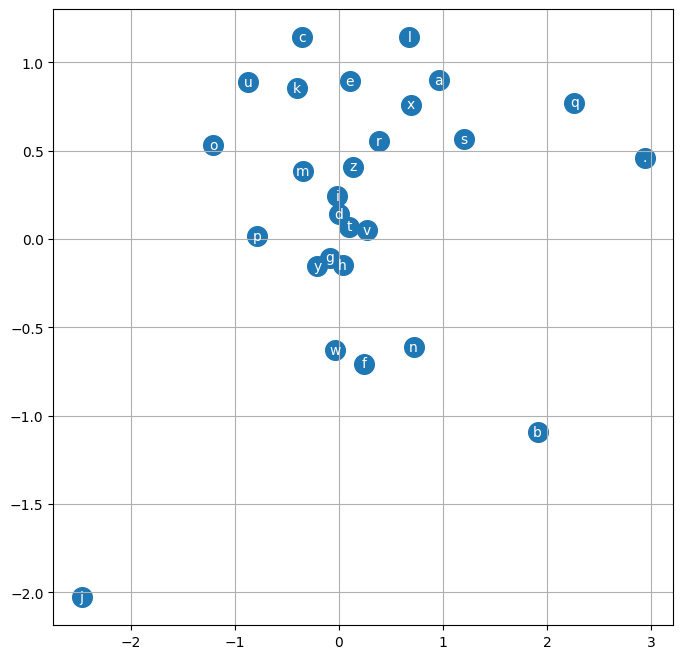

In [230]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va="center", color='white')
plt.grid('minor')

In [238]:
#Generate samples:

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix ==0:
            break 

    print(''.join(itos[i] for i in out))

brian.
derie.
everlitzamise.
yaylonse.
daziu.
rayya.
samysterie.
daylan.
duo.
api.
jackianavery.
aizyne.
revchevek.
carlos.
zamateh.
anagtley.
emriyagzoriana.
behlanaveen.
pelyn.
cynah.


In [ ]:
brean